#Training a Neural Network in PyTorch#

PyTorch is a powerful, widely-used machine learning library. It has all the latest neural network layers and functions and supports GPU computation.

Most neural network research these days either happens in PyTorch or TensorFlow. Google Research develops TensorFlow while Facebook AI Research develops PyTorch. Functionally they are probably very similar, I just know a lot of people who use PyTorch and it seems like it might be somewhat easier for beginners to learn. It is important to have some experience in one of these two frameworks but if you understand the ideas and concepts you shouldn't have too much trouble moving between them.

The `torch` library provides the basic functions we need when dealing with `tensors`. `tensors` are a generalization of matrices to arbirtrary numbers of dimensions (a matrix is a 2D tensor). Types of tensors:


*   0 dimensional: Scalar
*   1 dimensional: Array
*   2 dimensional: Matrix
*   3 dimensional: Number cubey thingy
*   4 dimensional: ?????

Anywho, let's start with our opening chant to invoke the power of PyTorch to aid us. The last line is a special call to the GPU gods to smile on our endeavor.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Time For Some Data##

PyTorch has some built tools for downloading and loading common datasets. We'll be playing around with MNIST in this example. It is a dataset of 28x28 grayscale handwritten digits 0-9. There are 50,000 images in the training set and 10,000 in the test set.



In [2]:
def get_mnist_data():
  trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)

  testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                      transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False,
                                          num_workers=8)
  classes = range(10)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_mnist_data()

###Understanding Our Data ###
It's worthwhile to check out how our dataloader loads the images into tensors. We can print out the size of the loaded data in the `images` tensors.



In [3]:
# get some random training images
dataiter = iter(data['train'])
images, labels = dataiter.next()
print(images.size())

torch.Size([32, 1, 28, 28])


Our `images` tensor is 4-dimensional, (32 x 1 x 28 x 28)

PyTorch stores image data in (N x C x H x W) format. Thus the size of this tensor implies we have a mini-batch of 32 images, each have a single channel (grayscale), and each image is 28 x 28, so that makes sense!

We can use matplotlib to see what our data looks like:

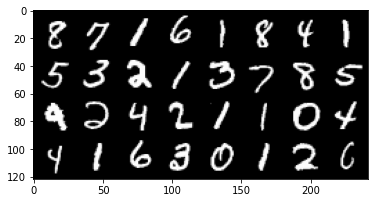

        8         7         1         6


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % data['classes'][labels[j]] for j in range(4)))


##A Simple Network##

First we'll build a very basic neural network with a single hidden layer of neurons. This means one fully connected layer of weights connects the input to the hidden neurons and one fully connected layer connects the hidden neurons to the output. We'll use the RELU activation function on the hidden neuron values as our nonlinearity.

These fully connected (or `nn.Linear`) layers expect a 2D input tensor where that is N x I where N is the number of data points in a mini batch and I is the number of inputs. However, our data is formatted in (N x C x H x W) right now so we need to tell PyTorch to rearrange it using `torch.flatten`.

After being `flatten`ed our data goes from (32 x 1 x 28 x 28) to being (32 x 784)

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self, inputs=28*28, hidden=512, outputs=10):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

###The Training Function ###

Now for training our network. Our `train` function takes as input the `net` to train and the `dataloader` for the training data. It also takes some optional parameters to control training.

For our network we'll be using PyTorch's built in `nn.CrossEntropyLoss`. This will apply a softmax to our network's output, calculate the log-probability assigned to each class, then try to minimize the negative log likelihood of our data (AKA maximize the likelihood)

For our optimizer we are using stochastic gradient descent with learning rate, momentum, and decay parameters.

In [6]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

###Training The Network###

We'll instantiate a new network and train it on our training data.

Our training function prints out some debug information about the epoch, batch number, and current loss values. It also returns a list of all the losses on our mini-batches so we can plot them all once training has finished.

[1,   100] loss: 1.353
[1,   200] loss: 0.516
[1,   300] loss: 0.413
[1,   400] loss: 0.377
[1,   500] loss: 0.350
[1,   600] loss: 0.336
[1,   700] loss: 0.288
[1,   800] loss: 0.282
[1,   900] loss: 0.267
[1,  1000] loss: 0.297
[1,  1100] loss: 0.260
[1,  1200] loss: 0.241
[1,  1300] loss: 0.236
[1,  1400] loss: 0.237
[1,  1500] loss: 0.214
[1,  1600] loss: 0.205
[1,  1700] loss: 0.191
[1,  1800] loss: 0.171


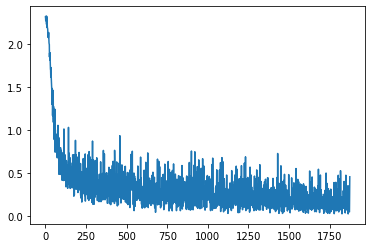

In [7]:
net = SimpleNet()

losses = train(net, data['train'])
plt.plot(losses)

##Testing The Network##

We trained our network! The loss went down! That's good, right? But how good is our network, exactly?

Well, we can try running our network on a few of our test images and see what happens:

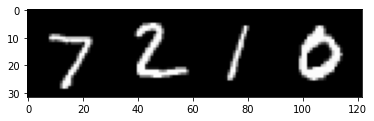

GroundTruth:      7     2     1     0
Predicted:        7     2     1     0


In [8]:
dataiter = iter(data['test'])
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

Pretty good so far. But we also want to be able to test the network on all of our data. Here's a function that can do just that, computing the accuracy on a full set of data:

In [9]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Now we can give it a try:

In [10]:
print("Current accuracy: %f" % accuracy(net, data['train']))

Current accuracy: 0.948917


##Experiments##

Now it's time to poke around a little bit with our models. First I just want this utility function to do window smoothing of data for us. As you may have noticed, we are doing *stochastic* gradient descent, so our losses for each mini-batch can vary quite dramatically. If we smooth them out a little bit they will be easier to look at when we plot them.

In [11]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='same')

###Learning Rate###

Let's experiment around with the learning rate of our model. Changing the learning rate should affect how fast our model converges and how accurate it is. We can see the effect when we plot out the loss function over time for models with different learning rates:

0.9537 0.9485 0.8954


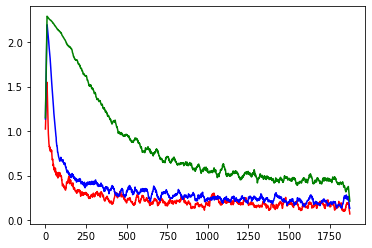

In [12]:
net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.01, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.001, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

###Momentum###

We are using the default value for momentum of `0.9`. Fix your value for the learning rate and try varying the values for momentum.

####**Question 1: What affect does changing the value for momentum have on your model's convergence and final accuracy?**####

Higher values for momentum means that the model tends to converge quicker - we can see this by comparing our loss graph before epoch 250, where the model with highest momentum decreases in loss the quickest and the model with lowest momentum takes longer to achieve a smaller decrease in loss.

However, high momentum isn't strictly better, as the model with largest momentum (0.9) achieved the worst final accuracy out of all three of these examples and the model with medium momentum (0.5) achieved the best. The spread in final accuracy between these test cases isn't too big either, with a 0.012 range.

Overall, increasing momentum noticeably increases convergence rate but has smaller effects on final accuracy.

0.9529 0.9618 0.9507


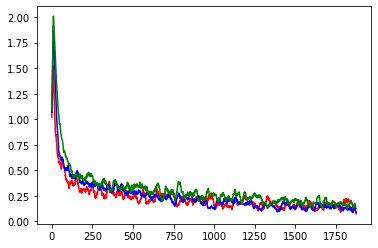

In [13]:
#TODO: Write your code here for experimenting with different values of momentum.

# I'm going to keep the best learning rate we found from earlier (0.1)

net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.9, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.5, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.1, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

0.9463 0.912 0.8976


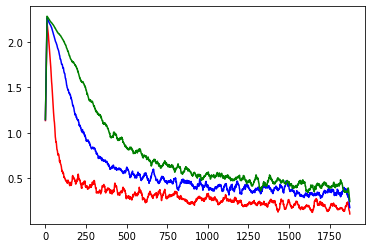

In [14]:
# Out of curiosity, I want to check that the results using default learning rate (0.01) aren't too different

net_high = SimpleNet()
losses_high = train(net_high, data['train'], momentum=0.9, verbose=0)
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], momentum=0.5, verbose=0)
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], momentum=0.1, verbose=0)
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_high, acc_mid, acc_low)

It looks like the conclusions we reached for momentum are mostly the same when we experiment using a different learning rate, it's just much more obvious what those conclusions are. (Higher momentum = faster convergence!)

Also, when using a faster learning rate momentum contributes much more to improved final accuracy. I think in this case it's because a learning rate of 0.01 is really, really slow and increasing momentum improves the convergence rate enough that the highest-momentum model has already converged, while the lowest-momentum model may still be converging.

###Weight Decay###

Right now we aren't using any weight decay with our model. However, it can be useful as a method of regularization if we are worried about overfitting.

Take your best performing model parameters from above for learning rate and momentum. Fix these parameters as you answer the following questions:

####**Question 2: Is our current model overfit or underfit to our training data? How can you tell?**####

There's no strong indication that our current model is either overfitted or underfitted. The training and testing dataset accuracy is similar, with around 0.96 accuracy for both. 

If our model had high accuracy on the training data but lower accuracy on the test data, that would suggest overfitting, since the predictive performance does not generalize to unseen data. It our model had low accuracy on both the training and test data, then we would be underfitting the data, likely because the model is not complex enough to capture meaningful relationships in the data.

####**Question 3: Try out some different values for weight decay. What effect do they have on model convergence? What about final accuracy? Does this match with what you would have expected? Why or why not?**####

Changing the values for weight decay slightly affects convergence rate, but the most visible effect is changing the final accuracy that each model converges to. The model with highest weight decay has the lowest final accuracy (and converges to that final accuracy at nearly the same rate as the other models), while the model with lowest (zero) weight decay has the highest final accuracy and faster convergence than all of the others.

This makes sense, since weight decay is meant to force the model to be more generalized and prevent overfitting. Since we didn't observe overfitting earlier, adding weight decay is only going to visibly decrease final test accuracy.

We can still observe that weight decay is doing what it's meant to do if we look at training and testing dataset accuracy: on the model with highest weight decay, there is no drop in accuracy when switching from training to testing dataset (actually there is a slight increase). However, on the model with lowest weight decay there is a 0.004 drop in accuracy - not enough to be obvious overfitting, but it hints at what it's meant to do.

0.83595 0.9256333333333333 0.9657666666666667
0.8433 0.9258 0.963


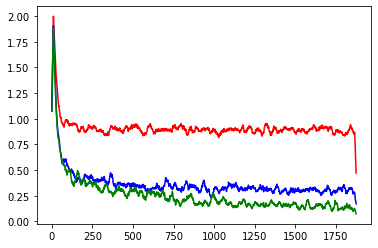

In [15]:
#TODO: Write your code here for experimenting with different weight decay

# The best learning rate we found from earlier is 0.1
# The best momentum we used with this learning rate is 0.5

net_high = SimpleNet()
losses_high = train(net_high, data['train'], lr=.1, momentum=0.5, decay=0.1, verbose=0)
acc_t_high = accuracy(net_high, data['train'])
acc_high = accuracy(net_high, data['test'])
plt.plot(smooth(losses_high,20), 'r-')


net_mid = SimpleNet()
losses_mid = train(net_mid, data['train'], lr=.1, momentum=0.5, decay=0.01, verbose=0)
acc_t_mid = accuracy(net_mid, data['train'])
acc_mid = accuracy(net_mid, data['test'])
plt.plot(smooth(losses_mid,20), 'b-')


net_low = SimpleNet()
losses_low = train(net_low, data['train'], lr=.1, momentum=0.5, decay=0.0, verbose=0)
acc_t_low = accuracy(net_low, data['train'])
acc_low = accuracy(net_low, data['test'])
plt.plot(smooth(losses_low,20), 'g-')

print(acc_t_high, acc_t_mid, acc_t_low)
print(acc_high, acc_mid, acc_low)

###A Bigger Model###

Before we used a very simple model but now it's time to try adding some complexity. Create a network that takes as input the 28x28 image, 10 outputs, and any number of layers as long as it has fewer than 2,000,000 connections. Our simple network before had 784\*512 + 512\*10 = 406,528 connections.

Use only fully connected (`nn.Linear`) layers (we'll get to other layer types soon). However, play around with different [activation functions](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions), [losses](https://pytorch.org/docs/stable/nn.html#loss-functions), and hyperparameter settings. You can also try different training regimes. For example, you could try lowering the learning rate during training by calling our training method twice like this:

    train(net, data['train'], epochs=5, lr=.1)
    train(net, data['train'], epochs=3, lr=.01)
    train(net, data['train'], epochs=2, lr=.001)

Maybe it works better? Why did I choose those particular numbers? Who knows! It's deep learning, no one really knows what will work, you have to just try things and see.

Experiment with different network architectures and settings to get the most accurate model.

####**Question 4: Describe your final model architecture. How did you come up with the number of layers and number of neurons at each layer?**####

Our final model architecture consists of a 3 layer multi-layer perceptron with 1000, 500, and 10 hidden units at each layer. We came up with these values for the number of layers and number of neurons at each layer by experimenting with several architectures of different "shapes". We had:
- A deep and narrow network (many hidden layers, each layer containing relatively few nodes).
- A shallow and wide network (one hidden layer, but that hidden layer contained many nodes).
- A network that expanded and contracted (a small number of hidden layers with a varying number of nodes: from few, to many, to few).
- A network that started wide and gradually contracted (two hidden layers, the first layer with many nodes and the second layer with fewer).

We found that the shallow+wide network and the wide+contracting network performed better than the other two, with negligible differences between their performance based on how they were trained.

Our rationale was that differently shaped architectures might encode spatial and contextual information differently. Perhaps the wider layers could capture more spatial information regarding the image as a whole, and maybe the narrower layers could focus on representing image information in smaller regions of the image. The specific values we used allow for much more connectivity (1289000 to be exact). Experimentally, this architecture gave the best results.

####**Question 5: What hyperparameters did you experiment with? What values were good for them? Do you think your model was over or under fitting the data?**####

Guided by the conclusions we made earlier in this notebook, we had an idea of values for certain hyperparameters that should be constant. For example, since we saw that overfitting was not a concern earlier, we kept the weight decay parameter at 0. Additionally, based on our previous experiments, we saw that using a value of 0.5 for momentum worked best.

We started by experimenting with epoch count, raising it from 1 to 5 to 10 training epochs. On the contracting and shallow+wide networks, training for 10 epochs produced accuracy in the range of 0.999 on the training dataset and 0.983 on the test dataset.

The difference between performance on train and test datasets indicated there was possibly very slight overfitting happening, so we shifted focus to experimenting with different weight decay values. However, increasing the weight decay from 0 to 0.001 or 0.01 decreased accuracy on both training and test datasets, so we kept it at 0.

Finally, we experimented with simultaneously lowering the learning rate and number of epochs trained for each successive learning rate (so to slow down training as we get closer to the accuracy maxima). Specifically, we trained with learning rate = 0.1 for 5 epochs, learning rate = 0.01 for 3 epochs, and learning rate = 0.001 for the last 2 epochs. This ended up producing the best results by a very tiny margin: training dataset accuracy 0.9993, test dataset accuracy 0.985. By increasing the weight decay to 0.0001 in the last learning phase, we improved the test dataset accuracy to 0.986.

On re-running these, we found that tiny improvements in performance due to changing learning rate or weight decay (on the last learning phase) did not replicate, but the improvements granted by increasing epoch count did. Overall, we still achieved a best performance of approx. 0.9993 accuracy on train dataset and 0.985 accuracy on test dataset by training 10 epochs with either constant or decreasing learning rate and minimal weight decay. This suggests that we are neither significantly overfitting nor underfitting the data. Only a good fit on the data would produce such high accuracy on the test set.

We considered running a full grid search over a broader hyperparameter space, but decided that it would be unlikely to yield further gains in performance. It is possible that changing learning rate has significant impact on more difficult datasets, but on MNIST it made little contribution.

In [16]:
#TODO: Write your new model and experiments here

class ExperiNet(nn.Module):
    #TODO: Change all this
    def __init__(self):
        super(ExperiNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class DeepAndNarrowNet(nn.Module):
    def __init__(self):
        super(DeepAndNarrowNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc6 = nn.Linear(256, 256)
        self.fc7 = nn.Linear(256, 256)
        self.fc8 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        return x

class ShallowAndWideNet(nn.Module):
    def __init__(self):
        super(ShallowAndWideNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 2500)
        self.fc2 = nn.Linear(2500, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class ExpandAndContractNet(nn.Module):
    def __init__(self):
        super(ExpandAndContractNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        return x

class ContractNet(nn.Module):
    def __init__(self):
        super(ContractNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

0.9677 0.9357 0.9535 0.9661


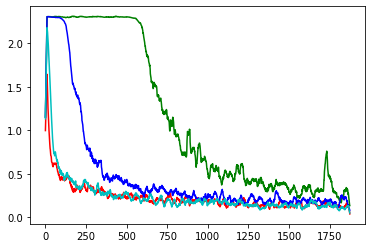

In [17]:
shallowWideNet = ShallowAndWideNet()
losses_shallowWide = train(shallowWideNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_shallowWide = accuracy(shallowWideNet, data['test'])
plt.plot(smooth(losses_shallowWide, 20), 'r-')

deepNarrowNet = DeepAndNarrowNet()
losses_deepNarrow = train(deepNarrowNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_deepNarrow = accuracy(deepNarrowNet, data['test'])
plt.plot(smooth(losses_deepNarrow, 20), 'g-')

expandContractNet = ExpandAndContractNet()
losses_expandContract = train(expandContractNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_expandContract = accuracy(expandContractNet, data['test'])
plt.plot(smooth(losses_expandContract, 20), 'b-')

contractNet = ContractNet()
losses_contract = train(contractNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_contract = accuracy(contractNet, data['test'])
plt.plot(smooth(losses_contract, 20), 'c-')

print(acc_shallowWide, acc_deepNarrow, acc_expandContract, acc_contract)

0.9662


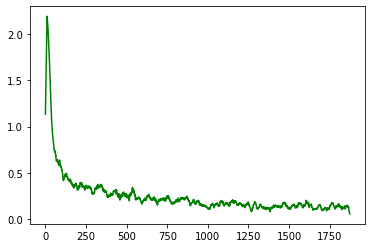

In [18]:
contractNet = ContractNet()
losses_contract = train(contractNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_contract = accuracy(contractNet, data['test'])
plt.plot(smooth(losses_contract, 20), 'g-')

print(acc_contract)

0.9485


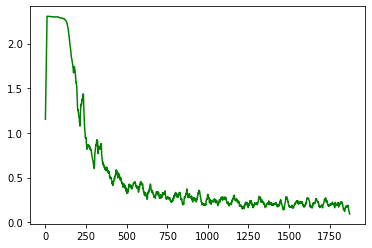

In [19]:
expandContractNet = ExpandAndContractNet()
losses_expandContract = train(expandContractNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_expandContract = accuracy(expandContractNet, data['test'])
plt.plot(smooth(losses_expandContract, 20), 'g-')

print(acc_expandContract)

0.9645


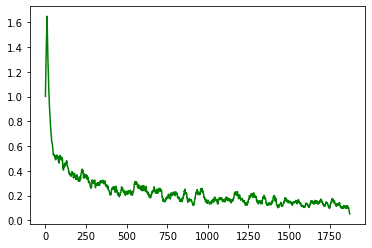

In [20]:
shallowWideNet = ShallowAndWideNet()
losses_shallowWide = train(shallowWideNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_shallowWide = accuracy(shallowWideNet, data['test'])
plt.plot(smooth(losses_shallowWide, 20), 'g-')

print(acc_shallowWide)

0.9346


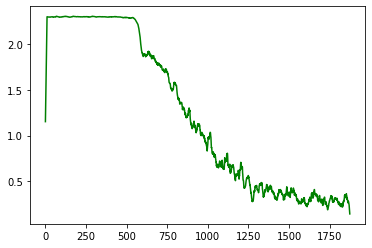

In [21]:
deepNarrowNet = DeepAndNarrowNet()
losses_deepNarrow = train(deepNarrowNet, data['train'], lr=.1, momentum=0.5, decay=0, verbose=0)
acc_deepNarrow = accuracy(deepNarrowNet, data['test'])
plt.plot(smooth(losses_deepNarrow, 20), 'g-')

print(acc_deepNarrow)

0.9946 0.9795


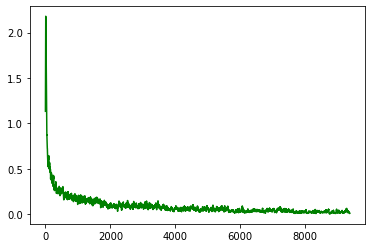

In [22]:
contractNet = ContractNet()
losses_contract = train(contractNet, data['train'], epochs=5, lr=.100, momentum=0.5, decay=0, verbose=0)
acc_train_contract = accuracy(contractNet, data['train'])
acc_contract = accuracy(contractNet, data['test'])
plt.plot(smooth(losses_contract, 20), 'g-')

print(acc_train_contract, acc_contract)

0.9996833333333334 0.9861
0.998 0.9832
0.9861833333333333 0.9802


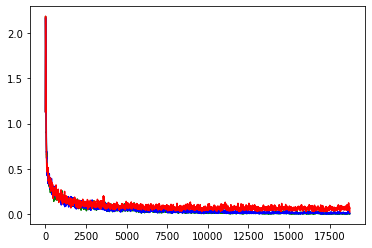

In [23]:
contractNet_0decay = ContractNet()
losses_contract0 = train(contractNet_0decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0, verbose=0)
acc_train_contract0 = accuracy(contractNet_0decay, data['train'])
acc_contract0 = accuracy(contractNet_0decay, data['test'])
plt.plot(smooth(losses_contract0, 20), 'g-')

contractNet_1decay = ContractNet()
losses_contract1 = train(contractNet_1decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0.0001, verbose=0)
acc_train_contract1 = accuracy(contractNet_1decay, data['train'])
acc_contract1 = accuracy(contractNet_1decay, data['test'])
plt.plot(smooth(losses_contract1, 20), 'b-')

contractNet_2decay = ContractNet()
losses_contract2 = train(contractNet_2decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0.001, verbose=0)
acc_train_contract2 = accuracy(contractNet_2decay, data['train'])
acc_contract2 = accuracy(contractNet_2decay, data['test'])
plt.plot(smooth(losses_contract2, 20), 'r-')

print(acc_train_contract0, acc_contract0)
print(acc_train_contract1, acc_contract1)
print(acc_train_contract2, acc_contract2)

0.9993166666666666 0.9857


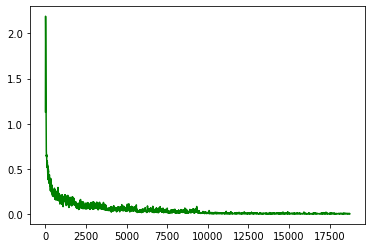

In [24]:
contractNet = ContractNet()
losses_contract = train(contractNet, data['train'], epochs=5, lr=.100, momentum=0.5, decay=0, verbose=0)
losses_contract += train(contractNet, data['train'], epochs=3, lr=.010, momentum=0.5, decay=0, verbose=0)
losses_contract += train(contractNet, data['train'], epochs=2, lr=.001, momentum=0.5, decay=0, verbose=0)
acc_train_contract = accuracy(contractNet, data['train'])
acc_contract = accuracy(contractNet, data['test'])
plt.plot(smooth(losses_contract, 20), 'g-')

print(acc_train_contract, acc_contract)

0.9993 0.9852


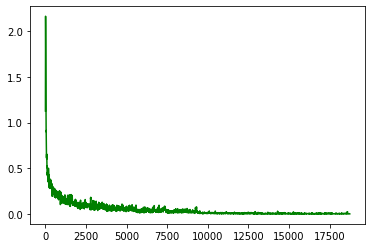

In [25]:
contractNet = ContractNet()
losses_contract = train(contractNet, data['train'], epochs=5, lr=.100, momentum=0.5, decay=0, verbose=0)
losses_contract += train(contractNet, data['train'], epochs=3, lr=.010, momentum=0.5, decay=0, verbose=0)
losses_contract += train(contractNet, data['train'], epochs=2, lr=.001, momentum=0.5, decay=0.0001, verbose=0)
acc_train_contract = accuracy(contractNet, data['train'])
acc_contract = accuracy(contractNet, data['test'])
plt.plot(smooth(losses_contract, 20), 'g-')

print(acc_train_contract, acc_contract)

0.9997833333333334 0.9835
0.99805 0.9815
0.97805 0.9715


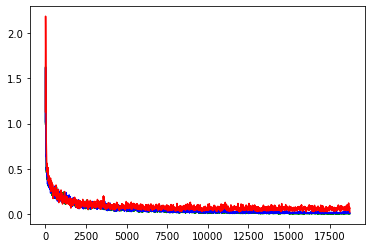

In [26]:
shallowWideNet_0decay = ShallowAndWideNet()
losses_shallowWide0 = train(shallowWideNet_0decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0, verbose=0)
acc_train_shallowWide0 = accuracy(shallowWideNet_0decay, data['train'])
acc_shallowWide0 = accuracy(shallowWideNet_0decay, data['test'])
plt.plot(smooth(losses_shallowWide0, 20), 'g-')

shallowWideNet_1decay = ShallowAndWideNet()
losses_shallowWide1 = train(shallowWideNet_1decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0.0001, verbose=0)
acc_train_shallowWide1 = accuracy(shallowWideNet_1decay, data['train'])
acc_shallowWide1 = accuracy(shallowWideNet_1decay, data['test'])
plt.plot(smooth(losses_shallowWide1, 20), 'b-')

shallowWideNet_2decay = ShallowAndWideNet()
losses_shallowWide2 = train(shallowWideNet_2decay, data['train'], epochs=10, lr=.100, momentum=0.5, decay=0.001, verbose=0)
acc_train_shallowWide2 = accuracy(shallowWideNet_2decay, data['train'])
acc_shallowWide2 = accuracy(shallowWideNet_2decay, data['test'])
plt.plot(smooth(losses_contract2, 20), 'r-')

print(acc_train_shallowWide0, acc_shallowWide0)
print(acc_train_shallowWide1, acc_shallowWide1)
print(acc_train_shallowWide2, acc_shallowWide2)

0.9985166666666667 0.9831


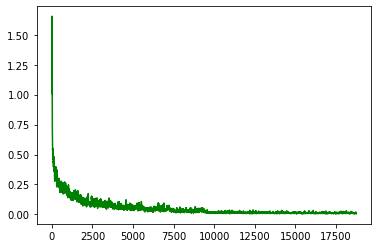

In [27]:
shallowWideNet = ShallowAndWideNet()
losses_shallowWide = train(shallowWideNet, data['train'], epochs=5, lr=.100, momentum=0.5, decay=0, verbose=0)
losses_shallowWide += train(shallowWideNet, data['train'], epochs=3, lr=.010, momentum=0.5, decay=0, verbose=0)
losses_shallowWide += train(shallowWideNet, data['train'], epochs=2, lr=.001, momentum=0.5, decay=0, verbose=0)
acc_train_shallowWide = accuracy(shallowWideNet, data['train'])
acc_shallowWide = accuracy(shallowWideNet, data['test'])
plt.plot(smooth(losses_shallowWide, 20), 'g-')

print(acc_train_shallowWide, acc_shallowWide)

0.9985 0.984


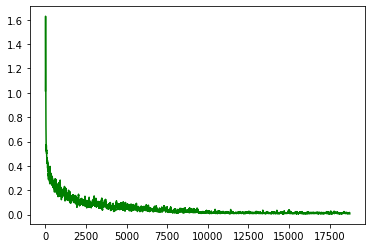

In [28]:
shallowWideNet = ShallowAndWideNet()
losses_shallowWide = train(shallowWideNet, data['train'], epochs=5, lr=.100, momentum=0.5, decay=0, verbose=0)
losses_shallowWide += train(shallowWideNet, data['train'], epochs=3, lr=.010, momentum=0.5, decay=0, verbose=0)
losses_shallowWide += train(shallowWideNet, data['train'], epochs=2, lr=.001, momentum=0.5, decay=0.0001, verbose=0)
acc_train_shallowWide = accuracy(shallowWideNet, data['train'])
acc_shallowWide = accuracy(shallowWideNet, data['test'])
plt.plot(smooth(losses_shallowWide, 20), 'g-')

print(acc_train_shallowWide, acc_shallowWide)

##Download and submit!##

Download your iPython notebook from Colab to your `hw0` directory. Then follow the instructions to collate and submit your homework.